In [1]:
from sliding_window_dataset import SlidingWindowDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('all_merged_data.csv', parse_dates=['datetime'])

# Extract datetime features
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['dayofweek'] = df['datetime'].dt.dayofweek

# Move new columns right after the index column (assumed to be the first column)
cols = list(df.columns)
# Remove the datetime and new columns from their current positions
cols.remove('datetime')
for col in ['trip_number', 'year', 'month', 'day', 'dayofweek']:
    cols.remove(col)
# Insert new columns after the index column (position 1)
for i, col in enumerate(['trip_number', 'year', 'month', 'day', 'dayofweek']):
    cols.insert(i, col)
# Drop datetime and reorder colaumns
df = df[cols]
df = df.set_index(['trip_number', df.index])

df = df.iloc[:, 4:-4]

scaler = StandardScaler()
df[df.columns] = scaler.fit_transform(df)

df.head()

RPM       THR      Fdet    Speed      Twat       INJ  \
trip_number                                                                
1           0 -1.188042 -0.774647 -0.129733 -1.14949  2.137515 -0.546603   
            1 -1.190809 -0.774647 -0.129733 -1.14949  2.137515 -0.558783   
            2 -1.187489 -0.774647 -0.129733 -1.14949  2.137515 -0.549648   
            3 -1.190809 -0.774647 -0.129733 -1.14949  2.137515 -0.567918   
            4 -1.190809 -0.774647 -0.129733 -1.14949  2.137515 -0.549648   

                    AIR       GBC   ADC_LAM       UOZ     Press     COEFF  \
trip_number                                                                 
1           0 -0.768447 -0.741901 -1.083910 -0.799740 -0.586234  0.803674   
            1 -0.770018 -0.748435  0.648997 -0.745914 -0.580413 -0.572897   
            2 -0.770804 -0.754585 -1.214696 -0.888169 -0.583647  0.344817   
            3 -0.771590 -0.755354  0.714390 -0.684398 -0.575454 -1.031754   
            4 -0.771590 -0.753432 -1.280088 -0.745914 -0.579335  0.344817   

                   Tair       Fxx      Ubat       TPS      Gear  
trip_number                                                      
1           0  1.121436  0.061847 -1.371310 -0.848896 -0.874425  
            1  1.121436  0.061847  0.157012 -0.848896 -0.874425  
            2  1.121436  0.061847 -0.607149 -0.848896 -0.874425  
            3  1.121436  0.061847 -1.371310 -0.848896 -0.874425  
            4  1.121436  0.061847 -1.371310 -0.848896 -0.874425

In [3]:
df.columns

Index(['RPM', 'THR', 'Fdet', 'Speed', 'Twat', 'INJ', 'AIR', 'GBC', 'ADC_LAM',
       'UOZ', 'Press', 'COEFF', 'Tair', 'Fxx', 'Ubat', 'TPS', 'Gear'],
      dtype='object')

In [4]:
df = df.dropna()
dataset = SlidingWindowDataset(df, target=None, window_size=60, stride=60)
print(len(dataset))
print(dataset[0])

Building safe windows: 100%|██████████| 187/187 [00:00<00:00, 1119.01it/s]

7803
(tensor([[-1.1880, -0.7746, -0.1297,  ..., -1.3713, -0.8489, -0.8744],
        [-1.1908, -0.7746, -0.1297,  ...,  0.1570, -0.8489, -0.8744],
        [-1.1875, -0.7746, -0.1297,  ..., -0.6071, -0.8489, -0.8744],
        ...,
        [-1.0060, -0.6302, -0.1297,  ...,  0.1570, -0.8489, -0.8744],
        [-1.1156, -0.7024, -0.1297,  ..., -1.3713, -0.8489, -0.8744],
        [-1.1421, -0.7024, -0.1297,  ..., -0.6071, -0.8489, -0.8744]]), tensor([-1.1421, -0.7024, -0.1297, -1.0515,  2.3473, -0.3913, -0.7252, -0.5724,
        -1.1166, -0.9151, -0.3847,  2.1802,  1.2205,  0.0618, -0.6071, -0.8489,
        -0.8744]))


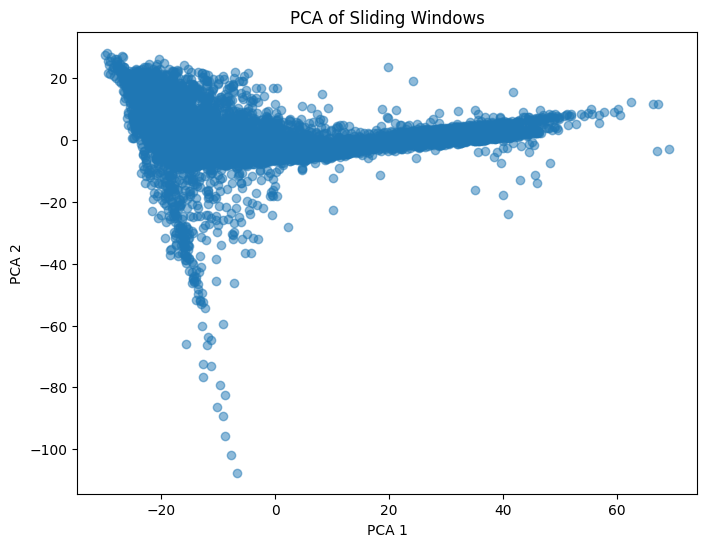

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Собираем все окна в массив
X = np.stack([window.numpy().flatten() for window, _ in dataset])

# PCA до 2 компонент
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Визуализация
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of Sliding Windows')
plt.show()

In [6]:
from torch.utils.data import DataLoader

loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [7]:
import torch.nn as nn

class MLPAutoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim=40):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, bottleneck_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

In [8]:
import torch
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = dataset[0][0].numel()
model = MLPAutoencoder(input_dim=input_dim, bottleneck_dim=40).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(100):  # увеличьте число эпох по необходимости
    model.train()
    total_loss = 0
    for batch, _ in loader:
        batch = batch.view(batch.size(0), -1).to(device)
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.size(0)
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataset):.6f}")

Epoch 1, Loss: 0.628119
Epoch 2, Loss: 0.436620
Epoch 3, Loss: 0.366677
Epoch 4, Loss: 0.331166
Epoch 5, Loss: 0.309582
Epoch 6, Loss: 0.295679
Epoch 7, Loss: 0.283303
Epoch 8, Loss: 0.275086
Epoch 9, Loss: 0.269522
Epoch 10, Loss: 0.264672
Epoch 11, Loss: 0.260143
Epoch 12, Loss: 0.257291
Epoch 13, Loss: 0.255503
Epoch 14, Loss: 0.251321
Epoch 15, Loss: 0.263952
Epoch 16, Loss: 0.250022
Epoch 17, Loss: 0.240162
Epoch 18, Loss: 0.238783
Epoch 19, Loss: 0.241176
Epoch 20, Loss: 0.250163
Epoch 21, Loss: 0.248076
Epoch 22, Loss: 0.238749
Epoch 23, Loss: 0.234770
Epoch 24, Loss: 0.230677
Epoch 25, Loss: 0.229533
Epoch 26, Loss: 0.230587
Epoch 27, Loss: 0.234227
Epoch 28, Loss: 0.232029
Epoch 29, Loss: 0.238362
Epoch 30, Loss: 0.228804
Epoch 31, Loss: 0.227760
Epoch 32, Loss: 0.224806
Epoch 33, Loss: 0.224130
Epoch 34, Loss: 0.223763
Epoch 35, Loss: 0.223140
Epoch 36, Loss: 0.225124
Epoch 37, Loss: 0.222677
Epoch 38, Loss: 0.221814
Epoch 39, Loss: 0.220721
Epoch 40, Loss: 0.218476
Epoch 41,

In [9]:
# 1. Создаём датасет с stride=60 (как для PCA)
dataset_stride60 = SlidingWindowDataset(df, target=None, window_size=60, stride=60)
loader_stride60 = DataLoader(dataset_stride60, batch_size=128, shuffle=False)

# 2. Получаем bottleneck-вектора из энкодера
model.eval()
all_bottlenecks = []

with torch.no_grad():
    for batch, _ in loader_stride60:
        batch = batch.view(batch.size(0), -1).to(device)
        bottleneck = model.encoder(batch)  # shape: [batch_size, 40]
        all_bottlenecks.append(bottleneck.cpu().numpy())

# 3. Собираем всё в один массив
all_bottlenecks = np.concatenate(all_bottlenecks, axis=0)  # shape: [num_windows, 40]

# 4. Сохраняем вектора, например, в .npy или .csv
np.save('bottleneck_vectors.npy', all_bottlenecks)
# или
np.savetxt('bottleneck_vectors.csv', all_bottlenecks, delimiter=',')

print("Bottleneck vectors shape:", all_bottlenecks.shape)

Building safe windows: 100%|██████████| 187/187 [00:00<00:00, 1010.77it/s]


Bottleneck vectors shape: (7803, 40)


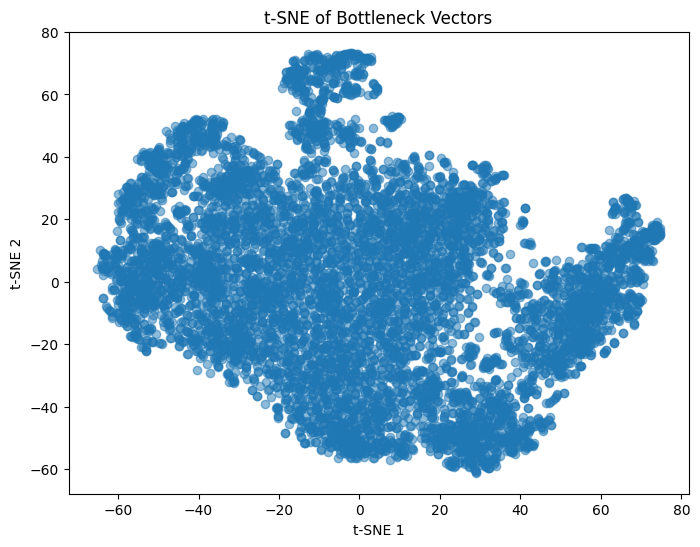

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# all_bottlenecks — это массив shape [num_windows, 40]
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(all_bottlenecks)

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], alpha=0.5)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE of Bottleneck Vectors')
plt.show()

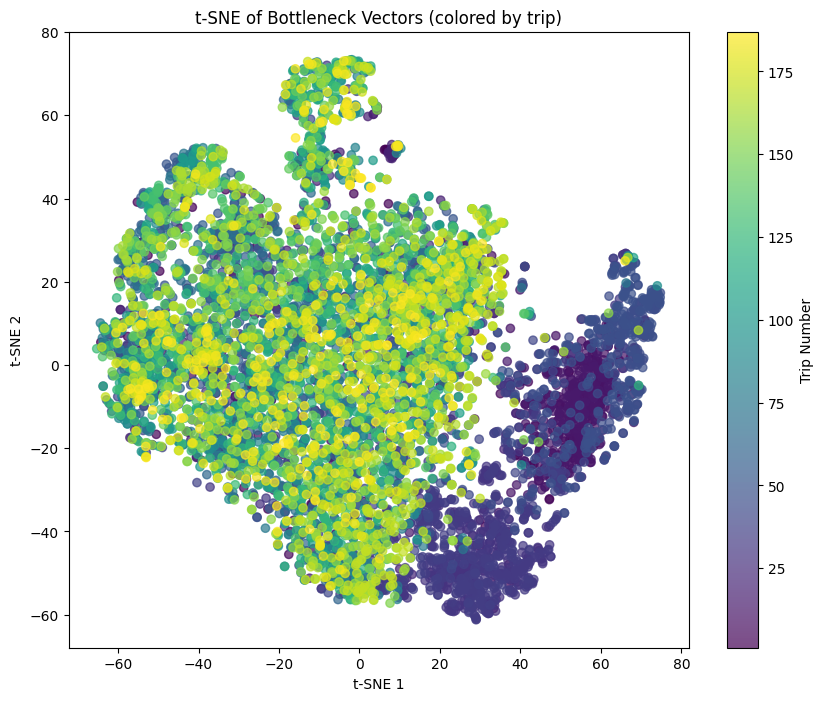

In [11]:
trip_numbers = []
for i in range(len(dataset_stride60)):
    # Get the valid window indices
    start_idx, end_idx = dataset_stride60.valid_windows[i]
    # Get the trip number from the first index of this window
    trip_num = df.index[start_idx][0]  # First level of MultiIndex is trip_number
    trip_numbers.append(trip_num)

trip_numbers = np.array(trip_numbers)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(all_bottlenecks)

plt.figure(figsize=(10,8))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=trip_numbers, alpha=0.7, cmap='viridis')
plt.colorbar(scatter, label='Trip Number')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE of Bottleneck Vectors (colored by trip)')
plt.show()


In [12]:
import plotly.express as px
import plotly.graph_objects as go

# Create interactive plot with Plotly
fig = px.scatter(
    x=X_tsne[:, 0], 
    y=X_tsne[:, 1], 
    color=trip_numbers,
    hover_data={'Trip': trip_numbers},
    labels={'x': 't-SNE 1', 'y': 't-SNE 2', 'color': 'Trip Number'},
    title='Interactive t-SNE of Bottleneck Vectors'
)

fig.show()

In [13]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

def plot_trip_highlight(trip_to_highlight):
    plt.figure(figsize=(10, 8))
    
    # Plot all points in gray
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c='lightgray', alpha=0.5, s=20)
    
    # Highlight selected trip
    if trip_to_highlight in trip_numbers:
        mask = trip_numbers == trip_to_highlight
        plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                   c='red', alpha=0.8, s=50, label=f'Trip {trip_to_highlight}')
        plt.legend()
    
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.title(f't-SNE of Bottleneck Vectors (Trip {trip_to_highlight} highlighted)')
    plt.show()

# Create interactive widget
trip_selector = widgets.IntSlider(
    value=trip_numbers[0],
    min=trip_numbers.min(),
    max=trip_numbers.max(),
    step=1,
    description='Trip:'
)

interactive_plot = widgets.interactive(plot_trip_highlight, trip_to_highlight=trip_selector)
display(interactive_plot)

interactive(children=(IntSlider(value=1, description='Trip:', max=187, min=1), Output()), _dom_classes=('widge…